In [1]:
pip install torch torchvision torchaudio


Note: you may need to restart the kernel to use updated packages.


In [40]:
import torch 
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, WeightedRandomSampler



# Lists to store metrics
train_acc_list = []
val_acc_list = []


df_tracks = pd.read_csv("high_popularity_spotify_data.csv")

target_genres = [
    "pop", "ambient", "classical", "electronic", 
    "folk", "country", "soul", "hip-hop", "jazz", "metal", "rock", "punk"
]

df_tracks = df_tracks[df_tracks["playlist_genre"].isin(target_genres)]

genre_map = {
    "metal" : "metal",
    "pop":"pop",
    "ambient": "ambient",
    "classical": "classical",
    "electronic": "electronic",
    
    "folk" : "folk_country",
    "country" : "folk_country",
    
    "soul" : "soul",
    "hip-hop" : "hip-hop", 
    "jazz": "jazz",
    
    "rock" : "rock_punk",
    "punk": "rock_punk"

}

df_tracks["playlist_genre"] = df_tracks["playlist_genre"].map(genre_map)
df_tracks = df_tracks.dropna(subset=["playlist_genre"])

#df_tracks = pd.read_csv("low_popularity_spotify_data.csv", index_col = 0)

#features are energy, tempo, danceability, loudness, liveness, valence, time_signature, speechiness



features = ["energy", "tempo", "danceability", "loudness",
                     "liveness", "valence", "time_signature",
                    "speechiness", "acousticness", "instrumentalness", "key"]

#top5_genres = df_tracks['playlist_genre'].value_counts().nlargest(5).index
#df_tracks = df_tracks[df_tracks['playlist_genre'].isin(top5_genres)]


X = df_tracks[features]
y = df_tracks["playlist_genre"]

label_encoder = LabelEncoder().fit(y)
y_encoded = label_encoder.transform(y)


scaler = StandardScaler()
X = scaler.fit_transform(X)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val   = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test  = torch.tensor(X_test, dtype=torch.float32).to(device)

y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_val   = torch.tensor(y_val, dtype=torch.long).to(device)
y_test  = torch.tensor(y_test, dtype=torch.long).to(device)

#y_train = torch.tensor(label_encoder.transform(y_train), dtype=torch.long)
#y_test  = torch.tensor(label_encoder.transform(y_test), dtype=torch.long)

#X_train = torch.tensor(X_train, dtype=torch.float32)
#X_test  = torch.tensor(X_test, dtype=torch.float32)


#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#X_train, y_train = X_train.to(device), y_train.to(device)
#X_test, y_test = X_test.to(device), y_test.to(device)






train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

input_size = X_train.shape[1]

class MLP(nn.Module):
    def __init__(self, input_size, num_classes=None):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, num_classes),
        
        )
    def forward(self, x):
        return self.net(x)

        
classes = label_encoder.classes_
num_features = X_train.shape[1]
num_classes = len(classes)
model = MLP(input_size=num_features, num_classes=num_classes).to(device)



criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)


epochs = 80
best_val_acc = 0
patience = 10
patience_counter = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for xb, yb in train_loader:
        #xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
 

    train_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    with torch.no_grad():
        val_out = model(X_val)
        val_loss = criterion(val_out, y_val)
        val_pred = val_out.argmax(1)
        val_acc = (val_pred == y_val).float().mean().item()

    scheduler.step(val_loss)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
   # scheduler.step()
    #epoch_loss = running_loss / len(train_loader.dataset)

    
   # if (epoch + 1) % 10 == 0:
    #    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

model.load_state_dict(torch.load("best_model.pt"))
model.eval()
with torch.no_grad():
    preds = model(X_test)
    predicted = preds.argmax(dim=1)
    acc = (predicted == y_test).float().mean()

    print(f"\nTest Accuracy: {acc.item()*100:.2f}%")

predicted_genres = label_encoder.inverse_transform(predicted.cpu().numpy())

y_true = y_test.cpu().numpy()
y_pred = predicted.cpu().numpy()



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered.

Test Accuracy: 53.22%


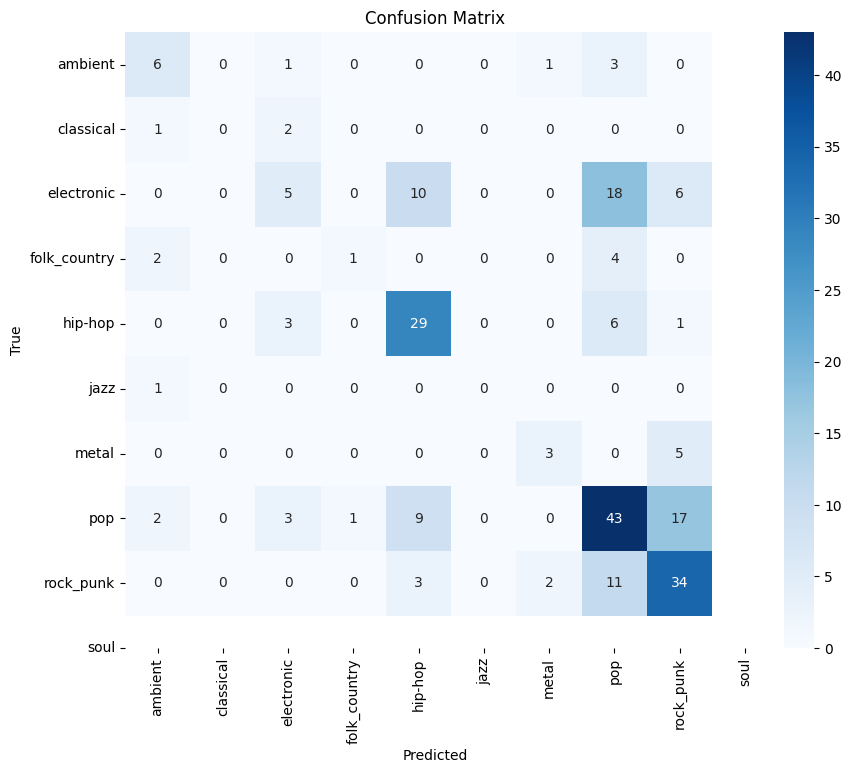

In [39]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()